# Music project
Laura Ferrini 5110577

Alberto Giussani 5116545

Giuseppe Latronico 5110276

# Downoload packages

In [ ]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
from torch.nn.modules import dropout
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image 

! pip install torchmetrics
import torchmetrics 
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import confusion_matrix,f1_score,classification_report, ConfusionMatrixDisplay
import seaborn as sns
from torchmetrics import ConfusionMatrix as CM
import plotly.colors
import plotly.graph_objects as go
import plotly.subplots
plt.ion()
from sklearn.model_selection import KFold
from torch.utils.data import TensorDataset, random_split, SubsetRandomSampler, ConcatDataset

# Introduction

The aim of this project is to implement a deep neural network model capable of predicting the music genre of a song. The model is trained on the GTZAN Dataset [(link to the original Kaggle dataset)](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification).
The dataset contains the Mel Spectrograms images of 1000 songs. The files were collected in 2000-2001 from a variety of sources including personal CDs, radio, microphone recordings, to represent a variety of recording conditions.
In each Mel spectrogram image, we can observe on the y-axis the Mel scale and on the x-axis the Time. The colours represent the Amplitude scale.
Hence our task is image (spectograms) classification.

# Import the dataset

In the following section we are going to import our `csv file`, in which: 
- the column `image` identifies the image's name
- the column `label` classifies the image accordingly to its belongingness to one of the following genres: *blues, classical, country, disco, hiphop, jazz, metal, pop, reggae*.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
music_set = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Music/music_def.csv", sep = ";")
music_set

,image,label
0,blues.00000.png,blues
1,blues.00001.png,blues
2,blues.00002.png,blues
3,blues.00003.png,blues
4,blues.00004.png,blues
...,...,...
995,rock.00095.png,rock
996,rock.00096.png,rock
997,rock.00097.png,rock
998,rock.00098.png,rock


The following transforms the labels (responses) into its corresponding index, ranging from $0$ to $9$.

In [ ]:
music_set["label"].replace(["blues", "classical", "country",
                            "disco", "hiphop", "jazz",
                            "metal", "pop", "reggae", "rock"],
                           range(10), inplace=True)
music_set

,image,label
0,blues.00000.png,0
1,blues.00001.png,0
2,blues.00002.png,0
3,blues.00003.png,0
4,blues.00004.png,0
...,...,...
995,rock.00095.png,9
996,rock.00096.png,9
997,rock.00097.png,9
998,rock.00098.png,9


## Class Music
We now define the class `Music`to perform two operations:
- Load the images matching them with both their names and  labels.
- Crop images to delete frames

We deal with a four channels tensor.
Below an exemple of the final images we will work on.

In [ ]:
class Music(Dataset):
  """music dataset"""

  def __init__(self, X, y, transform=None):

    self.X = X
    self.y = y
    self.transform = transform

  def __len__(self):

    return len(music_set)

  def __getitem__(self, idx):

    img_name =  os.path.join("/content/drive/MyDrive/Colab Notebooks/Music", 
                             self.X[idx].replace(".", "", 1))
    image    = Image.open(img_name).crop((54,35,390,253))
    label    = self.y[idx]

    if self.transform:
      image = self.transform(image)

    return image, label

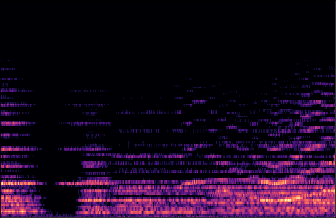

In [ ]:
music = Music(X = music_set["image"], y = music_set["label"])
music[150][0]

## Transformation to tensor
We resize the images in order to get a $224 \times 224$ format, and then we transform them into tensors. 

In [ ]:
composed = transforms.Compose([transforms.Resize([224,224]),
                               transforms.ToTensor()])

In [ ]:
music = Music(X = music_set["image"], y = music_set["label"], transform=composed)

The spectograms have been successfully transformed into $224 \times 224$ tensors having $4$ channels, as reported below.


In [ ]:
music[0][0], music[0][0].shape

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0471],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1216],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1255],
          ...,
          [0.2863, 0.8039, 0.5804,  ..., 0.4275, 0.4275, 0.4157],
          [0.0471, 0.4980, 0.2824,  ..., 0.2039, 0.3137, 0.3608],
          [0.1216, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.1216]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0471],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1216],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1255],
          ...,
          [0.0824, 0.3608, 0.1922,  ..., 0.1176, 0.1255, 0.2157],
          [0.0275, 0.1608, 0.0784,  ..., 0.0667, 0.1176, 0.1961],
          [0.1216, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.1216]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0471],
          [0.0078, 0.0157, 0.0157,  ..., 0.0157, 0.0157, 0.1255],
          [0.0078, 0.0157, 0.0157,  ...,

## Train and test set
We are now ready to split our dataset into train and test set. The $80\%$ of our dataset will be used as training, the remaining $20\%$ as test set.

In [ ]:
train_size = int(0.8 * len(music_set))
test_size = len(music_set) - train_size
train_music, test_music = torch.utils.data.random_split(music, [train_size, test_size])

## Data loader
We instantiate a `DataLoader` so that our dataset becomes now an iterable object.
As batch size we use a power of $2$:  $16$.

In [ ]:
train_dl = DataLoader(train_music, batch_size = 16, shuffle=True, drop_last=True)
test_dl = DataLoader(test_music, batch_size = 16, shuffle=True, drop_last=True)

# Models

In this section we present the arcithectures that  will be implemented on our dataset to classify the spectograms to music genres.
Three architectures will be presented:
- ResNet18
- Residual LSTM-CNN 
- Residual CNN-LSTM



## Training functions
We define below two funcitons to train our model with the different architectures. The first funciton uses the SGD as optimizer, the second Adam optimizer.
Both functions print train loss and train accuracy every ten epochs.
Both return: 
- loss_values: loss values
- accuracy_tr: accuracy on the trainging set
- loss_test: the loss on the test set
- accuracy on test set
- true: the true labels of the test 
- predicted: labels predicted by the model on the test set

The last two variables will be used to develop the confusion matrix.



In [ ]:
def trainer_SGD(net, train, test, num_epochs, lr, num_layers_Res=18, input_size = 768, hidden_size = 1024, num_directions = 1,
            num_hidden_LSTM = 1, batch_size = 32, no_classes = 10, sched_step_size=20,
             sched_gamma=0.1, image_channels=2)->list:

                          """This function can be used to train a model. Choose between models and pass the net name 
                          to the function"""
                          
                          metrics = torchmetrics.Accuracy(task="multiclass", num_classes=no_classes).to(device = "cuda")


                          if net != "ResNet":
                            hidden = (torch.zeros((num_directions*num_hidden_LSTM, batch_size, hidden_size), device="cuda"),
                                      torch.zeros((num_directions*num_hidden_LSTM, batch_size, hidden_size), device="cuda"))
                            
                          if net == "ResLSTM":
                            net = ResLSTM(Block, num_hidden_LSTM,  image_channels, no_classes, batch_size, input_size, hidden_size, hidden)
                          
                          if net == "ResCNN_LSTM":
                            net = ResCNN_LSTM(Block, num_hidden_LSTM,  image_channels, no_classes, batch_size, input_size, hidden_size, hidden)

                          if net == "ResNet":
                            net = ResNet(num_layers=num_layers_Res, block=Block, image_channels=4, num_classes=no_classes)

                              

                          net.cuda()  
                          loss_values  = []
                          accuracy_tr  = []
                          loss_test    = []
                          optimizer    = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, nesterov=True)
                          scheduler    = torch.optim.lr_scheduler.StepLR(optimizer, step_size=sched_step_size, gamma=sched_gamma)
                          loss         = nn.CrossEntropyLoss()
                          true         = []
                          predicted    = []

                          for i, epoch in enumerate(range(num_epochs)):
                            
                            net.train()
                            batch_loss, acc = 0.0, 0
                            
                            for (X, y) in train:
                              X = X.cuda()
                              y = y.cuda()
                              optimizer.zero_grad()
                              y_hat = net(X)
                              l = loss(y_hat, y)
                              l.backward()
                              optimizer.step()
                              batch_loss += l.item() * X.size(0)
                              acc += metrics(y_hat, y)

                            acc_batch = acc / len(train)
                            accuracy_tr.append(acc_batch)
                            overall_l = batch_loss/len(train.sampler)
                            loss_values.append(overall_l)

                            if i % 10 == 0:
                              print(f"Train Loss is: {overall_l}","|" ,
                                  f"Train Accuracy is: {acc_batch}", "|")
                              
                            metrics.reset()

                          net.eval()
                          with torch.no_grad():
                            batch_loss_test, acc_test = 0.0, 0
                            for (X_test, y_test) in test:
                              X_test     = X_test.cuda()
                              y_test     = y_test.cuda()
                              y_hat_test = net(X_test)
                              l = loss(y_hat_test, y_test)
                              batch_loss_test += l.item() * X_test.size(0)
                              true.append(y_test)
                              predicted.append(y_hat_test.argmax(dim=1))
                              acc_test += metrics(y_hat_test, y_test)
                              metrics.reset()
                            
                            acc_test_batch = acc_test / len(test)
                            loss_test.append(batch_loss_test/len(test.sampler))
                          
                            
                          return loss_values, accuracy_tr, loss_test, acc_test_batch, true, predicted


In [ ]:
def trainer_Adam(net, train, test, num_epochs, lr, num_layers_Res=18, input_size = 768, hidden_size = 1024, num_directions = 1,
            num_hidden_LSTM = 1, batch_size = 32, no_classes = 10, image_channels=2)->list:

                          """This function can be used to train a model. Choose between models and pass the net name 
                          to the function"""
                          
                          metrics = torchmetrics.Accuracy(task="multiclass", num_classes=no_classes).to(device = "cuda")


                          if net != "ResNet":
                            hidden = (torch.zeros((num_directions*num_hidden_LSTM, batch_size, hidden_size), device="cuda"),
                                      torch.zeros((num_directions*num_hidden_LSTM, batch_size, hidden_size), device="cuda"))
                            
                          if net == "ResLSTM":
                            net = ResLSTM(num_hidden_LSTM, Block, image_channels, no_classes,
                                           batch_size, input_size, hidden_size, hidden)
                            
                          if net == "ResCNN_LSTM":
                            net = ResCNN_LSTM(num_hidden_LSTM, Block, image_channels, no_classes,
                                           batch_size, input_size, hidden_size, hidden)
                            
                          if net == "ResNet":
                            net = ResNet(num_layers=num_layers_Res, block=Block, image_channels=4, num_classes=no_classes)

                              

                          net.cuda()  
                          loss_values  = []
                          accuracy_tr  = []
                          loss_test    = []
                          optimizer    = torch.optim.Adam(net.parameters(), lr=lr)
                          loss         = nn.CrossEntropyLoss()
                          true         = []
                          predicted    = []

                          
                          for i, epoch in enumerate(range(num_epochs)):
                            
                            net.train()
                            batch_loss, acc = 0.0, 0
                            
                            for (X, y) in train:
                              X = X.cuda()
                              y = y.cuda()
                              optimizer.zero_grad()
                              y_hat = net(X)
                              l = loss(y_hat, y)
                              l.backward()
                              optimizer.step()
                              batch_loss += l.item() * X.size(0)
                              acc += metrics(y_hat, y)

                            acc_batch = acc / len(train) 
                            accuracy_tr.append(acc_batch)
                            overall_l = batch_loss/len(train.sampler)
                            loss_values.append(overall_l)

                            if i % 10 == 0:
                              print(f"Train Loss is: {overall_l}","|" ,
                                  f"Train Accuracy is: {acc_batch}", "|")
                              
                            metrics.reset()

                          net.eval()
                          with torch.no_grad():
                            batch_loss_test, acc_test = 0.0, 0
                            for (X_test, y_test) in test:
                              X_test = X_test.cuda()
                              y_test = y_test.cuda()
                              y_hat_test = net(X_test)
                              l = loss(y_hat_test, y_test)
                              batch_loss_test += l.item() * X_test.size(0)
                              true.append(y_test)
                              predicted.append(y_hat_test.argmax(dim=1))
                              acc_test += metrics(y_hat_test, y_test)
                              metrics.reset()
                            
                            acc_test_batch = acc_test / len(test)
                            loss_test.append(batch_loss_test/len(test.sampler))
                          
                            
                          return loss_values, accuracy_tr, loss_test, acc_test_batch, true, predicted


## Plotting functions
We define here a function to plot train loss and train accuracy.

In [ ]:
def plotting(loss_values, precision_tr, net):
  tr_acc_resnet2=[]
  for i in precision_tr:
    tr_acc_resnet2.append(i.item())
  fig = go.Figure(data=go.Scatter(x=np.arange(len(loss_values)), y=loss_values , name='Train Loss'))
  fig.add_scatter(x=np.arange(len(tr_acc_resnet2 )), y=tr_acc_resnet2 , line=dict(color="orange", width=2),mode = "lines" , name='Train accuracy')
  fig.update_layout(title="Train loss and Train accuracy - " + net)
  fig.show()

We define the function `confusion_matrix` to plot a standard confusion matrix, and then we define `confusion_matrix2` that plots the confusion matrix with accuracies on the main diagonal. 

In [ ]:
m_genres = ["blues", "classical", "country", "disco", "hiphop", "jazz","metal", "pop", "reggae", "rock"]

In [ ]:
def confusion_matrix(predicted, true, batch_size , net , labels):
  pred = []
  
  for i in predicted:
    if len(i)==batch_size:
      pred.append(i.tolist())

  t = []
  for j in true:     
    if len(j)==batch_size:
      t.append(j.tolist()) 

  ConfMatr = CM(task="multiclass", num_classes=10) # ConfusionMatrix imported as CM
  cm       = ConfMatr(torch.Tensor(pred), torch.Tensor(t))
  cm       = cm.tolist()
  df_cm    = pd.DataFrame(cm, columns=labels, index=labels)
  fig, ax = plt.subplots(figsize=(10,5)) 
  sns.heatmap(df_cm, annot=True)
  plt.title('Confusion Matrix'+net, fontsize = 20) # title with fontsize 20
  plt.ylabel('True', fontsize = 15) # x-axis label with fontsize 15
  plt.xlabel('Predicted', fontsize = 15) # y-axis label with fontsize 15
  plt.show()

In [ ]:
def confusion_matrix2(predicted, true, batch_size , net , labels):
  pred = []
  
  for i in predicted:
    if len(i)==batch_size:
      pred.append(i.tolist())

  t = []
  for j in true:     
    if len(j)==batch_size:
      t.append(j.tolist()) 

  ConfMatr = CM(task="multiclass", num_classes=10) # ConfusionMatrix imported as CM
  cm       = ConfMatr(torch.Tensor(pred), torch.Tensor(t))
  cm=cm/torch.sum(cm , dim=0)
  cm       = cm.tolist()
  df_cm    = pd.DataFrame(cm, columns=labels, index=labels)

  fig, ax = plt.subplots(figsize=(10,5)) 
  sns.heatmap(df_cm, annot=True)
  plt.title('Confusion Matrix'+net, fontsize = 20) # title with fontsize 20
  plt.ylabel('True', fontsize = 15) # x-axis label with fontsize 15
  plt.xlabel('Predicted', fontsize = 15) # y-axis label with fontsize 15
  plt.show()

In [ ]:

def print_class_report(trues, predictions, batch_size, labels = m_genres):
  tr = [None] * batch_size * len(trues)
  pr = [None] * batch_size * len(predictions)
  a = 0 
  for i, j in zip(trues, predictions):
    for k in range(len(i)):
      i = list(i)
      j = list(j)
      tr[a] = i[k].item()
      pr[a] = j[k].item()
      a += 1
  
  tr = torch.Tensor(tr)
  pr = torch.Tensor(pr)
  print(classification_report(tr, pr, target_names = labels))


We also defined some functions to plot the results of the K-Fold cross validation we performed below.

In [ ]:
def performance_kfold(tr_l, tr_acc, valid_l, valid_acc):
  tr_loss2=[]
  for i in tr_l:
    tr_loss2.append(i)
  tr_acc2 = []
  for i in tr_acc:
    tr_acc2.append(i.item())
  valid_acc2 = []
  for i in valid_acc:
    valid_acc2.append(i.item())

  avg_train_loss = np.mean(np.asarray(tr_loss2))
  avg_test_loss = np.mean(np.asarray(valid_l))
  avg_train_acc = np.mean(np.asarray(tr_acc2))
  avg_test_acc = np.mean(np.asarray(valid_acc2))

  print('Performance of {} fold cross validation'.format(k))
  print("Average Training Loss: {:.4f} \t Average Test Loss: {:.4f} \t Average Training Acc: {:.3f} \t Average Test Acc: {:.3f}".format(avg_train_loss,avg_test_loss,avg_train_acc,avg_test_acc))

  


In [ ]:
def loss_Kfold(train_l, valid_l, net):
  tr_loss2=[]
  for i in history['train_loss']:
    tr_loss2.append(i)
  fig = go.Figure(data=go.Scatter(x=np.arange(len(tr_loss2)), y=tr_loss2, name='Train Loss'))
  fig.add_scatter(x=np.arange(len(valid_l)), y = valid_l, line=dict(color="orange", width=2),mode = "lines" , name='Validation Loss')
  fig.update_layout(title="Train loss and Validation loss | K-fold cross validation - " + net)
  fig.show()

In [ ]:
def acc_Kfold(train_acc, valid_acc, net):
  tr_acc2 = []
  for i in train_acc:
    tr_acc2.append(i.item())

  valid_acc2 = []
  for i in valid_acc:
    valid_acc2.append(i.item())
  
  fig = go.Figure(data=go.Scatter(x=np.arange(len(tr_acc2)), y=tr_acc2, name='Train Accuracy'))
  fig.add_scatter(x=np.arange(len(valid_acc2)), y = valid_acc2, line=dict(color="orange", width=2),mode = "lines" , name='Validation Accuracy')
  fig.update_layout(title="Train accuracy and Validation accuracy | K-fold cross validation - " + net)
  fig.show()

# ResNet18
We started fitting ResNet18 to check its performance on this dataset as well. The architecture is the same we defined in the previous file for the art dataset. 

## The architecture

In [ ]:
class Block(nn.Module):
    def __init__(self, num_layers, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()

        self.num_layers   = num_layers
        self.in_channels  = in_channels
        self.out_channels = out_channels
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn3   = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

In [ ]:
class ResNet(nn.Module):
    def __init__(self, num_layers, block, image_channels, num_classes):
        super(ResNet, self).__init__()
        
        if num_layers == 18:
            layers = [2, 2, 2, 2]
        elif num_layers == 34:
            layers = [3, 4, 6, 3]
            
        self.in_channels = 64
        self.conv1       = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1         = nn.BatchNorm2d(64)
        self.relu        = nn.ReLU()
        self.maxpool     = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNetLayers
        self.layer1 = self.make_layers(num_layers, block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self.make_layers(num_layers, block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self.make_layers(num_layers, block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self.make_layers(num_layers, block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc      = nn.Linear(512, num_classes)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.softmax(self.fc(x))
        return x

    def make_layers(self, num_layers, block, num_residual_blocks, intermediate_channels, stride):
        layers = []

        identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, intermediate_channels,
                                                      kernel_size=1, stride=stride),
                                            nn.BatchNorm2d(intermediate_channels))
        layers.append(block(num_layers, self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels 
        for i in range(num_residual_blocks - 1):

            layers.append(block(num_layers, self.in_channels, intermediate_channels)) 
            
        return nn.Sequential(*layers)


## Training ResNet18

We now train our model.

In [ ]:
tr_l, acc_tr, ts_l, acc_ts, true, pred = trainer_Adam("ResNet", train_dl, test_dl, 100, 0.002, image_channels=4, batch_size=16)


Train Loss is: 2.007511100769043 | Train Accuracy is: 0.2849999964237213 |
Train Loss is: 1.0990627753734588 | Train Accuracy is: 0.6037499904632568 |
Train Loss is: 0.5441905492544175 | Train Accuracy is: 0.8187499642372131 |
Train Loss is: 0.1701832539960742 | Train Accuracy is: 0.9387499690055847 |
Train Loss is: 0.020439247041940688 | Train Accuracy is: 0.9950000047683716 |
Train Loss is: 0.17552369579207153 | Train Accuracy is: 0.9437499642372131 |
Train Loss is: 0.028102554944343865 | Train Accuracy is: 0.9912499785423279 |
Train Loss is: 0.17818629774614236 | Train Accuracy is: 0.9399999976158142 |
Train Loss is: 0.00258533786967746 | Train Accuracy is: 0.9987499713897705 |
Train Loss is: 0.20868072380311786 | Train Accuracy is: 0.9350000023841858 |


## Results 

The results from the final report and the confusion matrix below are encouraging. 

In [ ]:
print_class_report(true, pred, 16, m_genres)

              precision    recall  f1-score   support

       blues       0.65      0.76      0.70        17
   classical       0.73      0.79      0.76        14
     country       0.44      0.58      0.50        19
       disco       0.56      0.38      0.45        24
      hiphop       0.88      0.61      0.72        23
        jazz       0.69      0.55      0.61        20
       metal       0.71      0.89      0.79        19
         pop       0.35      0.64      0.45        14
      reggae       0.73      0.48      0.58        23
        rock       0.37      0.37      0.37        19

    accuracy                           0.59       192
   macro avg       0.61      0.60      0.59       192
weighted avg       0.62      0.59      0.59       192



- Precision: out of all songs the model labelled as hiphop $88\%$ of those actually belonging to the category 

- Recall: out of all the songs that actually belong to the metal genre, the model correctly labelled $89\%$

- F1 Score: is the armonic mean of precision and recall 

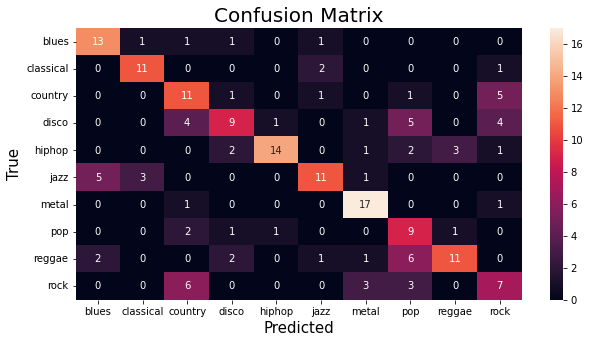

In [ ]:
confusion_matrix(pred, true, 16, "ResNet18", m_genres)

We can observe from the confusion matrix that the classification capability of the model is very good for every music genre.

In [ ]:
plotting(train_loss_resnet, train_prec_resnet, 'ResNet18')

## K-Fold Cross Validation 

We split the dataset into two subsets `train_valid_set` and `test_set`. On the former we will perform K-Fold cross validation whereas the latter is used as test set.

In [ ]:
train_valid_size = int(0.9 * len(music_set)) #use 90% of our data to perform LOOOCV
test_size        = len(music_set) - train_valid_size #keep out the 10 percent in order to have a better idea of the performances of our model 
#on complitely unseen data


In [ ]:
train_valid_set, test_set  = torch.utils.data.random_split(music, [train_valid_size, test_size])

We proceed exactly as in the previous file but this time we perform 5 epochs per fold. 

In [ ]:
num_epochs = 5
batch_size = 16
k          = 10
splitter   = KFold(n_splits=10,shuffle=True,random_state=42)
foldperf={}


Below we define the training and validation functions that are used at each epoch to train the model on $(K-1)$ folds and validate it on the $K-th$ fold. 

In [ ]:
def train_epoch(dataloader, loss_fn, net):

  train_loss, train_correct = 0.0,0
  metrics = torchmetrics.Accuracy("multiclass", num_classes=10).to(device="cuda")

  net.train()  #train the model
  
  for (X, y) in dataloader:
      X = X.cuda()
      y = y.cuda()
      optimizer.zero_grad()
      y_hat = net(X)
      l = loss_fn(y_hat, y)
      l.backward()
      optimizer.step()
      train_loss+= l.item() * X.size(0)

      true = y
      pred = net(X)
      train_acc = metrics(y_hat, y)
      metrics.reset()

  return train_loss, train_acc


def valid_epoch(dataloader ,loss_fn, net):
    
    valid_loss, val_correct=0.0, 0
    metrics = torchmetrics.Accuracy("multiclass", num_classes=10).to(device="cuda")

    net.eval()
    for (X, y) in dataloader:

      X     = X.cuda()
      y     = y.cuda()
      y_hat = net(X)
      l     = loss_fn(y_hat, y)

      valid_loss+= l.item() * X.size(0)
      true = y
      pred = net(X)
      valid_acc = metrics(y_hat, y)
      metrics.reset()

    return valid_loss , valid_acc

In [ ]:
history = {'train_loss': [], 'valid_loss': [],'train_acc':[],'valid_acc':[]}

net        = ResNet(18, Block, 4, 10)
net.cuda()
optimizer = torch.optim.SGD(net.parameters(), lr=0.02)

for fold, (train_idx, val_idx) in enumerate(splitter.split(np.arange(train_valid_size))):

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler  = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(train_valid_set, batch_size = batch_size, sampler = train_sampler)
    valid_loader  = DataLoader(train_valid_set, batch_size = batch_size, sampler = valid_sampler)

    

    for epoch in range(num_epochs):

        train_loss, train_acc = train_epoch(train_loader, nn.CrossEntropyLoss(), net)
        valid_loss, valid_acc = valid_epoch(valid_loader, nn.CrossEntropyLoss(), net)

        train_loss = train_loss / len(train_loader.sampler)
        valid_loss = valid_loss / len(valid_loader.sampler)
      

        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,
                                                                                                             num_epochs,
                                                                                                             train_loss,
                                                                                                             valid_loss,
                                                                                                             train_acc,
                                                                                                             valid_acc))
        history['train_loss'].append(train_loss)
        history['valid_loss'].append(valid_loss)
        history['train_acc'].append(train_acc)
        history['valid_acc'].append(valid_acc)   

Fold 1
Epoch:1/5 AVG Training Loss:2.263 AVG Test Loss:2.217 AVG Training Acc 0.40 % AVG Test Acc 0.10 %
Epoch:2/5 AVG Training Loss:2.180 AVG Test Loss:2.172 AVG Training Acc 0.40 % AVG Test Acc 0.20 %
Epoch:3/5 AVG Training Loss:2.142 AVG Test Loss:2.215 AVG Training Acc 0.20 % AVG Test Acc 0.20 %
Epoch:4/5 AVG Training Loss:2.112 AVG Test Loss:2.106 AVG Training Acc 0.40 % AVG Test Acc 0.30 %
Epoch:5/5 AVG Training Loss:2.078 AVG Test Loss:2.094 AVG Training Acc 0.20 % AVG Test Acc 0.50 %
Fold 2
Epoch:1/5 AVG Training Loss:2.047 AVG Test Loss:2.051 AVG Training Acc 0.50 % AVG Test Acc 0.20 %
Epoch:2/5 AVG Training Loss:2.018 AVG Test Loss:2.037 AVG Training Acc 0.20 % AVG Test Acc 0.60 %
Epoch:3/5 AVG Training Loss:1.981 AVG Test Loss:1.991 AVG Training Acc 0.50 % AVG Test Acc 0.30 %
Epoch:4/5 AVG Training Loss:1.962 AVG Test Loss:2.068 AVG Training Acc 0.40 % AVG Test Acc 0.30 %
Epoch:5/5 AVG Training Loss:1.936 AVG Test Loss:1.990 AVG Training Acc 0.40 % AVG Test Acc 0.50 %
Fold 3

In [ ]:
performance_kfold(history['train_loss'], history['train_acc'], history['valid_loss'], history['valid_acc'])

Performance of 10 fold cross validation
Average Training Loss: 1.7021 	 Average Test Loss: 1.7379 	 Average Training Acc: 0.754 	 Average Test Acc: 0.736


In [ ]:
loss_Kfold(history['train_loss'], history['valid_loss'], "ResNet")

We can see that train loss constantly decreases while validation loss is not as smooth in its descent. Still the overall picture is fairly good. 

In [ ]:
acc_Kfold(history['train_acc'], history['valid_acc'], "ResNet")

In [ ]:
def test(loss_fn, net, batch_size):
    
    dataloader = DataLoader(test_set, batch_size = batch_size)
    test_loss = 0.0
    metrics = torchmetrics.Accuracy("multiclass", num_classes=10).to(device="cuda")

    net.eval()
    for (X, y) in dataloader:

      X     = X.cuda()
      y     = y.cuda()
      y_hat = net(X)
      l     = loss_fn(y_hat, y)

      test_loss+= l.item() * X.size(0)
      true = y
      pred = net(X)
      test_acc = metrics(y_hat, y)
      metrics.reset()

    return test_loss/len(dataloader.sampler) , test_acc

In [ ]:
test(nn.CrossEntropyLoss(), net)

(1.9555054664611817, tensor(0.2500, device='cuda:0'))

The accuracy on the test set is not good as expected. Therefore we proceed our analysis by defining some new architectures. 

# Residual LSTM_CNN 
From the beginning, we have noticed that the spectograms are a peculiar kind of image. Indeed, they are characterized by a sequential dimension: on the x-axis there is time, and the evolution of the spectogram along time is determinant in detecting the music genre. So, to take advantage of this fact, we have decided to add LSTM layers to the architecture, exploiting the memory of this layers to retain temporal information. 

At first we have tried to implement a sequential convolutional LSTM network, but the results were poor. This was probably because of the network's depth, which was causing a degradation problem. As we could read on the paper [Kaiming He](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf/), residual connections solve the degradation issue.
Hence we have written a residual version of our sequential LSTM-CNN. 

In [ ]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
    
        super(Block, self).__init__()

        self.in_channels  = in_channels
        self.out_channels = out_channels
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn3   = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

In [ ]:
class ResLSTM(nn.Module):
    def __init__(self, block, num_layers,  image_channels, num_classes, batch_size, input_size, hidden_size, hidden):
        super(ResLSTM, self).__init__()

        self.num_classes = num_classes
        self.batch_size = batch_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.hidden = hidden
        layers = [2, 2, 2, 2]
        self.in_channels = 64
        self.conv1       = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1         = nn.BatchNorm2d(64)
        self.relu        = nn.ReLU()
        self.maxpool     = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNetLayers
        self.layer1 = self.make_layers( block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self.make_layers( block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self.make_layers( block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self.make_layers( block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc      = nn.Linear(512, num_classes)
        self.softmax = nn.Softmax()

    def forward(self, x):

      x = x.view(self.batch_size, 224, 896)
      x = x.permute(0, 2, 1)
      out, _ = self.lstm(x, self.hidden)
      out = out.reshape(self.batch_size, 8, 224, 224)
      out = self.conv1(out)
      out = self.bn1(out)
      out = self.relu(out)
      out = self.maxpool(out)

      out = self.layer1(out)
      out = self.layer2(out)
      out = self.layer3(out)
      out = self.layer4(out)

      out = self.avgpool(out)
      out = out.reshape(out.shape[0], -1)
      out = self.fc(out)
      
      return out

    def make_layers(self,  block, num_residual_blocks, intermediate_channels, stride):
        layers = []

        identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, intermediate_channels,
                                                      kernel_size=1, stride=stride),
                                            nn.BatchNorm2d(intermediate_channels))
        layers.append(block( self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels #* self.expansion # 256
        for i in range(num_residual_blocks - 1):

            layers.append(block( self.in_channels, intermediate_channels)) # 256 -> 64, 64*4 (256) again
            
        return nn.Sequential(*layers)


In [ ]:
tr_l_reslstm, acc_tr_reslstm, ts_l_reslstm, acc_ts_reslstm, true_reslstm, pred_reslstm = trainer_SGD("ResLSTM", train_dl, test_dl, 80, 0.02, input_size = 224, hidden_size = 448, num_hidden_LSTM=2, 
                                                     image_channels = 8, batch_size= 16)

Train Loss is: 2.7516282868385313 | Train Accuracy is: 0.1599999964237213 |
Train Loss is: 1.6913196444511414 | Train Accuracy is: 0.33124998211860657 |
Train Loss is: 1.5328628516197205 | Train Accuracy is: 0.38874998688697815 |
Train Loss is: 1.430661985874176 | Train Accuracy is: 0.47749999165534973 |
Train Loss is: 1.1844019567966462 | Train Accuracy is: 0.5612499713897705 |
Train Loss is: 0.993451269865036 | Train Accuracy is: 0.606249988079071 |
Train Loss is: 0.801131141781807 | Train Accuracy is: 0.7012499570846558 |
Train Loss is: 0.7479884800314903 | Train Accuracy is: 0.73499995470047 |


In [ ]:
plotting(tr_l_reslstm, acc_tr_reslstm, "ResLstm-CNN")

Although the results on the training set are encouraging, as can be seen from the plot and print-outs above, the confusion matrix and the final report are not as good. Indeed some labels have remarkably high precision and recall, but the overall accuracy $(36\%)$ is not as high as that of ResNet $(59\%)$.
The model is not as good as ResNet in the classification task.

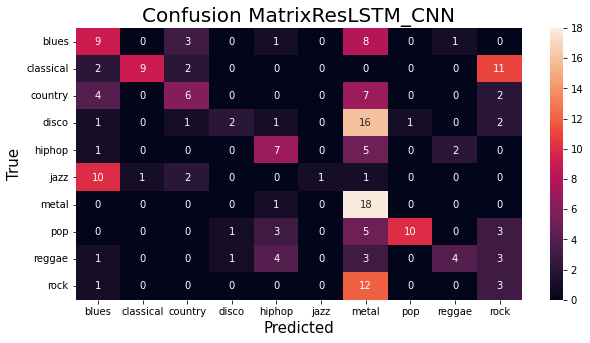

In [ ]:
confusion_matrix(pred_reslstm, true_reslstm, 16, "ResLSTM_CNN", m_genres)

In [ ]:
print_class_report(true_reslstm, pred_reslstm, 16, m_genres)

              precision    recall  f1-score   support

       blues       0.31      0.41      0.35        22
   classical       0.90      0.38      0.53        24
     country       0.43      0.32      0.36        19
       disco       0.50      0.08      0.14        24
      hiphop       0.41      0.47      0.44        15
        jazz       1.00      0.07      0.12        15
       metal       0.24      0.95      0.38        19
         pop       0.91      0.45      0.61        22
      reggae       0.57      0.25      0.35        16
        rock       0.12      0.19      0.15        16

    accuracy                           0.36       192
   macro avg       0.54      0.36      0.34       192
weighted avg       0.55      0.36      0.35       192



# Residual CNN_LSTM 
As the previous model did not fit so well the data, we decided to try another architecture.
This time, as opposite to what we did above, we added LSTM layers after the residual convolutions.

## Architecture
The following defines the **Residual CNN - LSTM** architecture:

In [ ]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        
        super(Block, self).__init__()

        self.in_channels  = in_channels
        self.out_channels = out_channels
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn3   = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

In [ ]:
class ResCNN_LSTM(nn.Module):
    def __init__(self, num_layers, block, image_channels, num_classes, batch_size, input_size, hidden_size, hidden):
        super(ResCNN_LSTM, self).__init__()

        self.num_classes = num_classes
        self.batch_size = batch_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.5)
        self.hidden = hidden
        layers = [2, 2, 2, 2]
        self.in_channels = 64
        self.conv1       = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1         = nn.BatchNorm2d(64)
        self.relu        = nn.ReLU()
        self.maxpool     = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.dropout = nn.Dropout(0.5)
        self.bn2         = nn.BatchNorm2d(128)
        self.bn3         = nn.BatchNorm2d(256)
        self.bn4         = nn.BatchNorm2d(512)

        # ResNetLayers
        self.layer1 = self.make_layers(block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self.make_layers(block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self.make_layers(block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self.make_layers(block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc      = nn.Linear(1024, num_classes)

    def forward(self, x):

      out = self.conv1(x)
      out = self.bn1(out)
      out = self.relu(out)
      out = self.maxpool(out)
      out = self.dropout(out)

      out = self.layer1(out)
      out = self.layer2(out)
      out = self.bn2(out)
      out = self.layer3(out)
      out = self.bn3(out)
      out = self.layer4(out)
      out = self.bn4(out)
      
      out = self.avgpool(out)

      out = out.reshape(-1, 512, 1)
      out, _ = self.lstm(out, self.hidden)
      out = out.flatten(1)
      out = self.dropout(out)
      out = self.fc(out)
      
      return out

    def make_layers(self, block, num_residual_blocks, intermediate_channels, stride):
        layers = []

        identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, intermediate_channels,
                                                      kernel_size=1, stride=stride),
                                            nn.BatchNorm2d(intermediate_channels))
        layers.append(block(self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels 
        for i in range(num_residual_blocks - 1):

            layers.append(block(self.in_channels, intermediate_channels)) 
            
        return nn.Sequential(*layers)


## Training 

In [ ]:
tr_l, acc_tr, ts_l, acc_ts, true, pred = trainer_Adam("ResCNN_LSTM", train_dl, test_dl, 100, 0.002, input_size=1, hidden_size=2, num_hidden_LSTM=2,
                                                      image_channels=4, batch_size=16)

Train Loss is: 2.3022976112365723 | Train Accuracy is: 0.1237499937415123 |
Train Loss is: 1.1929004681110382 | Train Accuracy is: 0.5737499594688416 |
Train Loss is: 0.6789755383133889 | Train Accuracy is: 0.7712500095367432 |
Train Loss is: 0.31880495596677066 | Train Accuracy is: 0.8937499523162842 |
Train Loss is: 0.16744116516783833 | Train Accuracy is: 0.9474999904632568 |
Train Loss is: 0.0654952487628907 | Train Accuracy is: 0.9799999594688416 |
Train Loss is: 0.139053953634575 | Train Accuracy is: 0.9562499523162842 |
Train Loss is: 0.11809542844421231 | Train Accuracy is: 0.9587499499320984 |
Train Loss is: 0.0528573608410079 | Train Accuracy is: 0.98499995470047 |
Train Loss is: 0.06353498285869136 | Train Accuracy is: 0.9799999594688416 |


In [ ]:
ts_l, acc_ts

([2.900475845336914], tensor(0.5625, device='cuda:0'))

In [ ]:
print_class_report(true, pred, 16, m_genres)

              precision    recall  f1-score   support

       blues       0.69      0.50      0.58        18
   classical       0.67      0.77      0.71        13
     country       0.65      0.72      0.68        18
       disco       0.54      0.33      0.41        21
      hiphop       0.62      0.64      0.63        25
        jazz       0.73      0.55      0.63        20
       metal       0.71      0.81      0.76        21
         pop       0.25      0.77      0.38        13
      reggae       0.86      0.25      0.39        24
        rock       0.47      0.47      0.47        19

    accuracy                           0.56       192
   macro avg       0.62      0.58      0.56       192
weighted avg       0.63      0.56      0.56       192



From the report above we can see that this model has a strongly improved performance with respect to the previous one.
With respect to ResNet instead we see little differences.
So we are satisfied with this architecture.

Below we plot the confusion matrix, which further confirms the goodness of fit of the model.

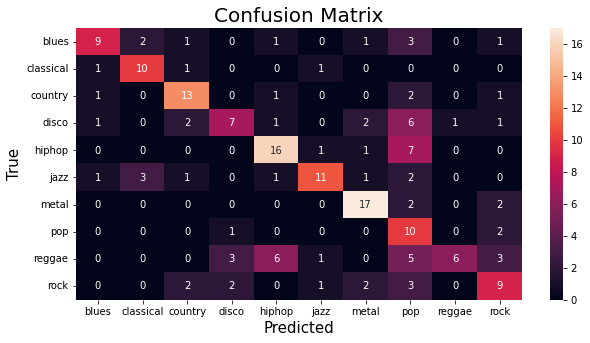

In [ ]:
confusion_matrix(pred, true, m_genres, 16)

To better understand the differences between this model and ResNet we compare their results in the cross validation.

## K-fold CV 

We proceed as before. 

In [ ]:
train_valid_size = int(0.8 * len(music_set))         # use 80% of our data to perform LOOOCV
test_size        = len(music_set) - train_valid_size # keep out the 20% in order to have a better idea of the performances of our model 
# on complitely unseen data


In [ ]:
train_valid_set, test_set  = torch.utils.data.random_split(music, [train_valid_size, test_size])

In [ ]:
num_epochs = 5
batch_size = 16
k          = 10
splitter   = KFold(n_splits=k,shuffle=True,random_state=42)
foldperf={}


In [ ]:
def train_epoch(dataloader, loss_fn, net):

  train_loss, train_acc = 0.0,0
  metrics = torchmetrics.Accuracy("multiclass", num_classes=10).to(device="cuda")
  net.train() 
  
  for (X, y) in dataloader:
    X = X.cuda()
    y = y.cuda()
    optimizer.zero_grad()
    y_hat = net(X)
    l = loss_fn(y_hat, y)
    l.backward()
    optimizer.step()
    train_loss += l.item() * X.size(0)
    train_acc  += metrics(y_hat, y)
    metrics.reset()

  acc_batch = train_acc / len(dataloader)

  return train_loss, acc_batch


def valid_epoch(dataloader ,loss_fn, net):
    
    valid_loss, valid_acc =0.0, 0
    metrics = torchmetrics.Accuracy("multiclass", num_classes=10).to(device="cuda")
    net.eval()

    for (X, y) in dataloader:
      X           = X.cuda()
      y           = y.cuda()
      y_hat       = net(X)
      l           = loss_fn(y_hat, y)
      valid_loss += l.item() * X.size(0)
      valid_acc  += metrics(y_hat, y)
      metrics.reset()

    acc_batch = valid_acc / len(dataloader)

    return valid_loss , acc_batch

In [ ]:
history    = {'train_loss': [], 'valid_loss': [],'train_acc':[],'valid_acc':[]}

hidden     = (torch.rand((2, 16, 2), device="cuda"),
              torch.rand((2, 16, 2), device="cuda"))
net        = ResCNN_LSTM(2, Block, 4, 10, 16, 1, 2, hidden)
net.cuda()
optimizer  = torch.optim.Adam(net.parameters(), lr=0.002)

for fold, (train_idx, val_idx) in enumerate(splitter.split(np.arange(train_valid_size))):
  
  print('Fold {}'.format(fold + 1))

  train_sampler  = SubsetRandomSampler(train_idx)
  valid_sampler  = SubsetRandomSampler(val_idx)
  train_loader   = DataLoader(train_valid_set, batch_size = batch_size, sampler = train_sampler)
  valid_loader   = DataLoader(train_valid_set, batch_size = batch_size, sampler = valid_sampler)

    

  for epoch in range(num_epochs):
    
    train_loss, train_acc = train_epoch(train_loader, nn.CrossEntropyLoss(), net)
    valid_loss, valid_acc = valid_epoch(valid_loader, nn.CrossEntropyLoss(), net)

    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
    train_acc  = train_acc * 100
    valid_acc  = valid_acc * 100
      
    print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,
                                                                                                             num_epochs,
                                                                                                             train_loss,
                                                                                                             valid_loss,
                                                                                                             train_acc,
                                                                                                             valid_acc))
        
    history['train_loss'].append(train_loss)
    history['valid_loss'].append(valid_loss)
    history['train_acc'].append(train_acc)
    history['valid_acc'].append(valid_acc) 

Fold 1
Epoch:1/5 AVG Training Loss:2.177 AVG Test Loss:4.314 AVG Training Acc 18.06 % AVG Test Acc 21.25 %
Epoch:2/5 AVG Training Loss:1.790 AVG Test Loss:5.257 AVG Training Acc 31.53 % AVG Test Acc 12.50 %
Epoch:3/5 AVG Training Loss:1.701 AVG Test Loss:3.287 AVG Training Acc 35.42 % AVG Test Acc 16.25 %
Epoch:4/5 AVG Training Loss:1.580 AVG Test Loss:2.823 AVG Training Acc 39.31 % AVG Test Acc 20.00 %
Epoch:5/5 AVG Training Loss:1.503 AVG Test Loss:2.869 AVG Training Acc 45.28 % AVG Test Acc 30.00 %
Fold 2
Epoch:1/5 AVG Training Loss:1.463 AVG Test Loss:1.473 AVG Training Acc 48.47 % AVG Test Acc 41.25 %
Epoch:2/5 AVG Training Loss:1.422 AVG Test Loss:2.611 AVG Training Acc 46.53 % AVG Test Acc 30.00 %
Epoch:3/5 AVG Training Loss:1.378 AVG Test Loss:2.351 AVG Training Acc 48.19 % AVG Test Acc 30.00 %
Epoch:4/5 AVG Training Loss:1.361 AVG Test Loss:3.264 AVG Training Acc 48.61 % AVG Test Acc 16.25 %
Epoch:5/5 AVG Training Loss:1.329 AVG Test Loss:2.772 AVG Training Acc 52.92 % AVG Tes

In [ ]:
performance_kfold(history['train_loss'], history['train_acc'], history['valid_loss'], history['valid_acc'])

Performance of 10 fold cross validation
Average Training Loss: 0.8785 	 Average Test Loss: 1.8984 	 Average Training Acc: 68.214 	 Average Test Acc: 49.825


We can see that the plots of loss and accuracy are not too different from those of ResNet. Although having larger oscillations we are satisfied of the overall behaviour of loss and accuracy. 

In [ ]:
loss_Kfold(history['train_loss'], history['valid_loss'], "ResCNN_LSTM")

In [ ]:
acc_Kfold(history['train_acc'], history['valid_acc'], "ResCNN_LSTM")

In [ ]:
def test(loss_fn, net, batch_size):
  
  dataloader = DataLoader(test_set, batch_size = batch_size, drop_last=True)
  test_loss, test_acc = 0.0, 0
  metrics = torchmetrics.Accuracy("multiclass", num_classes=10).to(device="cuda")

  net.eval()
  for (X, y) in dataloader:
    X     = X.cuda()
    y     = y.cuda()
    y_hat = net(X)
    l     = loss_fn(y_hat, y)

    test_loss+= l.item() * X.size(0)
    test_acc += metrics(y_hat, y)
    metrics.reset()

  acc_batch = test_acc / len(dataloader)
  test_loss = test_loss/len(dataloader.sampler)

  return test_loss , acc_batch

In [ ]:
test(nn.CrossEntropyLoss(), net, 16)

(2.8632324600219725, tensor(0.5260, device='cuda:0'))

The overall accuracy on completely unseen data (test set) is $52\%$, much higher than that of ResNet ($25\%$).

This result proves that the last architecture better parses the spectrograms with respect to ResNet.

# Conclusions 

Summarizing, we started by fitting ResNet18 and we obtained fairly good results. 

Anyway theoretically this architecture did not take into account the time dimension of our data. Therefore we were ignoring some useful information contained in the images.
So we decided to rely on a recurrent neural network to make the most of our data. In particular we chose to deal with LSTM because of its capability of keeping track of a longer window of sequential data. However we sticked to convolutional layers to extract information from our images.

The last model seems to be the most appropriate in dealing with our task.